# Import and settings

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

import os, re, gc, joblib
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42

import seaborn as sns
import plotnine as pln

warnings.simplefilter("ignore", category=pln.exceptions.PlotnineWarning)

import anndata
import scanpy as sc
import sctk as sk

np.set_printoptions(linewidth=180)
sc.settings.verbosity = 0
sk.set_figsize((4, 4))

In [94]:
from IPython.display import Image

# Load data

In [95]:
data_path = "../data"

metadata_csv = f"{data_path}/sample_metadata.csv"

# rna_h5ad = "scRNA_batch1_2.processed.20211220.h5ad"
# rna_raw_h5ad = f"{data_path}/20200715_scRNA_batch1_2/scRNA_batch1_2.raw.h5ad"
atacP_h5ad = f"{data_path}/atac/scATAC_PeakMatrix.processed.cellxgene.h5ad"
atacG_h5ad = f"{data_path}/atac/scATAC_GeneScoreMatrix.cellxgene.h5ad"
atacG_varname_list = f"{data_path}/atac/scATAC_GeneScoreMatrix.genes.tsv.gz"
integrated_h5ad = f"{data_path}/atac/scRNA_scATAC.down_sampled.multimap_integrated.h5ad"

## metadata

In [96]:
metadata = pd.read_csv(metadata_csv)

In [97]:
metadata["DOB"] = pd.to_datetime(metadata.DOB).dt.strftime("%d/%m/%Y")
metadata["date"] = pd.to_datetime(metadata.date).dt.strftime("%d/%m/%Y")

In [98]:
metadata["Sample"] = metadata.Sample.astype(str).astype("category")

In [99]:
metadata.bulkSeq.fillna("nan", inplace=True)
metadata.slide_look_other.fillna("nan", inplace=True)

## data

### peak count data

In [100]:
atacP_ad = sc.read(atacP_h5ad)

In [101]:
atacP_ad

AnnData object with n_obs × n_vars = 77712 × 407383
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'TSSEnrichment', 'Clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co', 'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm', 'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm', 'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm', 'predictedCell', 'predictedGroup', 'predictedScore', 'Annot', 'Clusters1', 'ReadsInPeaks', 'FRIP', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percen

In [102]:
atacP_ad.obs

,BlacklistRatio,DoubletEnrichment,DoubletScore,nDiFrags,nFrags,nMonoFrags,nMultiFrags,NucleosomeRatio,PromoterRatio,ReadsInBlacklist,...,log1p_n_genes,percent_mito,n_counts_mito,percent_ribo,n_counts_ribo,percent_hb,n_counts_hb,percent_top50,scrublet_score_z,annot1
index,,,,,,,,,,,,,,,,,,,,,
A11#GGACACCCAAGCCTTA-1,0.003560,0.826667,-0.000000,21941.0,64041.0,37125.0,4975.0,0.725010,0.168704,456.0,...,10.476527,0.0,0.0,0.0,0.0,0.0,0.0,0.271702,-0.000000,S5
A11#AACTGGTAGCGCCTAC-1,0.003975,0.906667,-0.000000,28270.0,60753.0,26802.0,5681.0,1.266734,0.133714,483.0,...,10.305681,0.0,0.0,0.0,0.0,0.0,0.0,0.345823,-0.000000,S5
A11#AACGAGGGTTTGCCAA-1,0.003965,0.866667,-0.000000,20405.0,58888.0,35658.0,2825.0,0.651467,0.131393,467.0,...,10.283327,0.0,0.0,0.0,0.0,0.0,0.0,0.336208,-0.000000,S1
A11#GCAACCGGTGGTACTT-1,0.003886,0.946667,-0.000000,18864.0,55969.0,34210.0,2895.0,0.636042,0.120808,435.0,...,10.273774,0.0,0.0,0.0,0.0,0.0,0.0,0.333840,-0.000000,S5
A11#TTACGTTAGCATACCT-1,0.004228,0.573333,-0.000000,21325.0,55469.0,30477.0,3667.0,0.820028,0.145820,469.0,...,10.368133,0.0,0.0,0.0,0.0,0.0,0.0,0.315886,-0.000000,S1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A08#CACTGAAGTTCCAATG-1,0.012099,0.800000,-0.000000,849.0,2149.0,1167.0,133.0,0.841474,0.115635,52.0,...,6.734592,0.0,0.0,0.0,0.0,0.0,0.0,7.875579,-0.000000,VE postcapillary venlue
A08#TTAGGTGCATCGGCCA-1,0.006836,0.400000,-0.000000,789.0,2121.0,1217.0,115.0,0.742810,0.168788,29.0,...,7.139660,0.0,0.0,0.0,0.0,0.0,0.0,5.563094,-0.000000,S5
A08#CCGTGAGTCGAACACT-1,0.003305,2.200000,5.255331,858.0,2118.0,1083.0,177.0,0.955679,0.165014,14.0,...,7.133296,0.0,0.0,0.0,0.0,0.0,0.0,5.397859,5.255331,PC


In [103]:
# Simon: Include only fibroblast cells
select_cells = ['S1', 'S2', 'S3', 'S3x', 'S4', 'S5', 'MF1', 'MF2', 'PC']
atacP_ad = atacP_ad[atacP_ad.obs.annot1.isin(select_cells), :]

In [104]:
#atacP_ad.obs.annot1.value_counts()

In [105]:
atacP_ad.X.data

array([3., 2., 2., ..., 2., 2., 2.], dtype=float32)

In [106]:
from sklearn.feature_extraction.text import TfidfTransformer

In [107]:
tfidf = TfidfTransformer()

In [108]:
atacP_X_tfidf = tfidf.fit_transform(atacP_ad.X)

In [109]:
atacP_tfidf_ad = anndata.AnnData(
    X=atacP_X_tfidf, obs=atacP_ad.obs.copy(), var=atacP_ad.var.copy(), obsm=atacP_ad.obsm.copy()
)

In [110]:
sc.pp.highly_variable_genes(
    atacP_tfidf_ad, min_disp=1, min_mean=0.0002, max_mean=0.02, subset=False
)

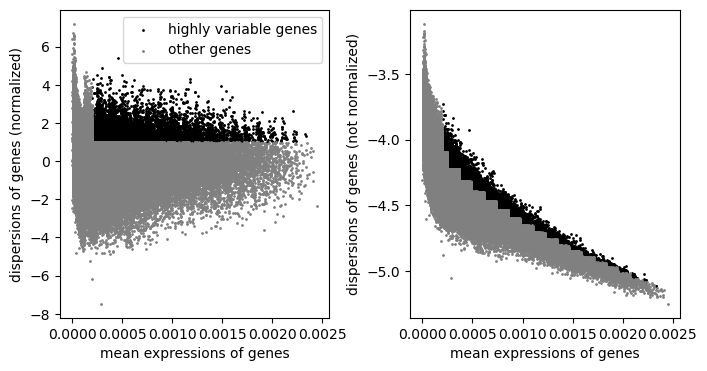

In [111]:
sc.pl.highly_variable_genes(
    atacP_tfidf_ad,
)

In [112]:
atacP_tfidf_ad.var.highly_variable.sum()

12098

In [113]:
atacP_tfidf_ad

AnnData object with n_obs × n_vars = 56689 × 407383
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'TSSEnrichment', 'Clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co', 'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm', 'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm', 'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm', 'predictedCell', 'predictedGroup', 'predictedScore', 'Annot', 'Clusters1', 'ReadsInPeaks', 'FRIP', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percen

In [114]:
# del atacP_ad  # Simon: needed at end of script for plotting

### gene accessibility score

In [115]:
atacG_ad = sc.read(atacG_h5ad)
atacG_varnames = pd.read_csv(atacG_varname_list, header=None, names=["gene"]).gene.values
atacG_ad.var_names = atacG_varnames
atacG_ad.obs["ATAC_SID"] = sk.regroup(
    atacG_ad,
    groupby="Sample",
    regroups={"A01": "NX02", "A02": "NX10", "A03": "NX18", "A04": "NX26"},
)
atacG_ad.obs = (
    atacG_ad.obs.reset_index()
    .merge(metadata, how="left", left_on="ATAC_SID", right_on="ATAC_SID")
    .set_index("index")
)

In [116]:
# Simon: Include only fibroblast cells
select_cells = ['S1', 'S2', 'S3', 'S3x', 'S4', 'S5', 'MF1', 'MF2', 'PC']
atacG_ad = atacG_ad[atacG_ad.obs.annot1.isin(select_cells), :]

In [117]:
atacG_ad

View of AnnData object with n_obs × n_vars = 56689 × 24919
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample_x', 'TSSEnrichment', 'Clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co', 'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm', 'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm', 'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm', 'predictedCell', 'predictedGroup', 'predictedScore', 'Annot', 'annot1', 'ATAC_SID', 'GEX_SID', 'GEX', 'ATAC', 'Sample_y', 'Donor', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq'
    var: 'seqnames', 'start', 'end', 'strand', 'name', 'idx'
    obsm: 'X_umap'

In [118]:
sk.calculate_qc(atacG_ad)

In [119]:
# Simon: this function appears to no longer be maintained in sctk
#sk.plot_qc(atacG_ad)

In [120]:
atacG_ad1 = atacG_ad[atacG_ad.obs.percent_top50 <= 15].copy()

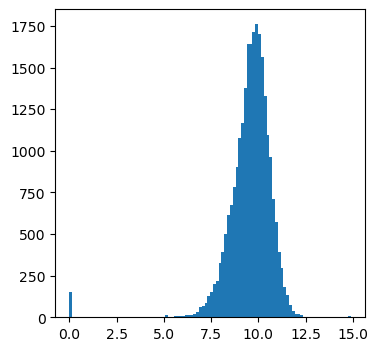

In [121]:
plt.hist(np.log1p(atacG_ad1.var.n_counts), 100);

In [122]:
atacG_ad1 = atacG_ad1[
    :, (np.log1p(atacG_ad1.var.n_counts) >= 7) & (np.log1p(atacG_ad1.var.n_counts) <= 12.5)
].copy()

In [123]:
sc.pp.normalize_total(atacG_ad1, target_sum=1e4)

In [124]:
atacG_ad1.X[0:5, :].sum(axis=1)

matrix([[10000.005],
        [10000.05 ],
        [ 9999.946],
        [10000.024],
        [ 9999.967]], dtype=float32)

In [125]:
sc.pp.log1p(atacG_ad1)

In [126]:
sc.pp.highly_variable_genes(atacG_ad1, min_mean=0.085, max_mean=1, min_disp=0.75)

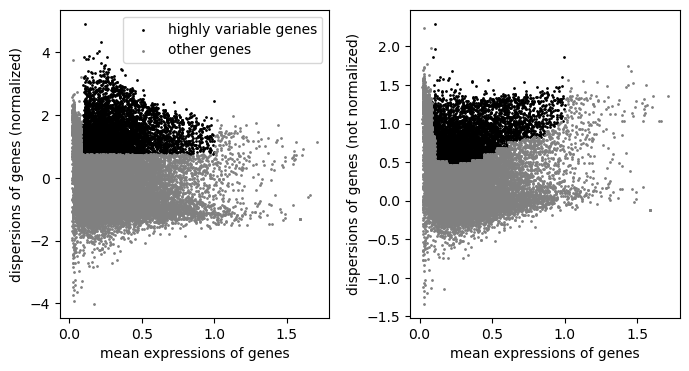

In [127]:
sc.pl.highly_variable_genes(atacG_ad1)

In [128]:
atacG_ad1.var.highly_variable.sum()

4801

# Run cNMF for gene accessibility score
Simon: Note that this analysis is exploratory. For the gene peak scores the resulting cNMF factors tend to be ill-defined.

In [129]:
def check_stat(cnmf_out_prefix, K, plot=False):
    stat_df = pd.concat(
        [
            pd.read_csv(f"{cnmf_out_prefix}.stats.k_{k}.consensus.csv", index_col=0).T
            for k in K
            if os.path.exists(f"{cnmf_out_prefix}.stats.k_{k}.consensus.csv")
        ],
        axis=0,
        ignore_index=True,
    )
    stat_df["k"] = stat_df.k.astype(int)
    stat_df["prediction_error"] = stat_df["prediction_error"] / 1e7

    if plot:
        pln.options.figure_size = (4, 4)
        print(
            pln.ggplot(stat_df, pln.aes(x="prediction_error", y="stability", label="k"))
            + pln.geom_line()
            + pln.geom_point()
            + pln.geom_text(nudge_x=0.01, nudge_y=0.002)
            + pln.theme_bw()
        )

    return stat_df

In [130]:
def examine_k(cnmf_out_prefix, k, adata=None, plot=False, n_top_genes=10):
    usage_df = pd.read_csv(
        f"{cnmf_out_prefix}.usage.k_{k}.consensus.csv.gz",
        index_col=0,
        names=[f"p{i+1}" for i in range(k)],
        skiprows=1,
    )

    spectra_df = pd.read_csv(
        f"{cnmf_out_prefix}.spectra.k_{k}.consensus.csv.gz",
        index_col=0,
    )

    top_k_inds = np.argsort(spectra_df.values)[:, -1 : -(n_top_genes + 1) : -1]

    norm_usage_df = usage_df / usage_df.sum(axis=0).values.reshape(1, k)

    if adata:
        adata.obs[f"cNMF_{k}program"] = np.argmax(norm_usage_df.values, axis=1)
        adata.obs[f"cNMF_{k}program"] = adata.obs[f"cNMF_{k}program"].astype("category")

        if plot:
            sk.clear_colors(adata)
            sk.plot_embedding(adata, basis="umap", groupby=f"cNMF_{k}program", annot="full")

    return pd.DataFrame(spectra_df.columns[top_k_inds], index=spectra_df.index)

In [131]:
gc.collect()

6655

In [42]:
!mkdir -p cNMF_atacG_fibro

In [56]:
# K = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
K = [8, 9]  # minimum example to look at

In [44]:
sk._utils.run_cNMF(
    atacG_ad1,
    K=K,
    use_rep="X",
    rep_type="lognorm",
    n_worker=16,
    use_cache=False,
    output_prefix="cNMF_atacG/cNMF_atacG_fibro",
)

k = 8 done
k = 9 done


Process ForkPoolWorker-38:
Traceback (most recent call last):
  File "/home/jovyan/my-conda-envs/ni_env2/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/jovyan/my-conda-envs/ni_env2/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jovyan/my-conda-envs/ni_env2/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/jovyan/my-conda-envs/ni_env2/lib/python3.10/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/jovyan/my-conda-envs/ni_env2/lib/python3.10/site-packages/sctk/_utils.py", line 663, in _run_NMF
    _, H, _ = non_negative_factorization(X, n_components=k, random_state=seed, **kwargs)
  File "/home/jovyan/my-conda-envs/ni_env2/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "/home/jovyan/m

KeyboardInterrupt: 

In [43]:
!ls cNMF_atacG/

cNMF_atacG.gene_spectra.k_10.csv.gz
cNMF_atacG.gene_spectra.k_11.csv.gz
cNMF_atacG.gene_spectra.k_12.csv.gz
cNMF_atacG.gene_spectra.k_13.csv.gz
cNMF_atacG.gene_spectra.k_14.csv.gz
cNMF_atacG.gene_spectra.k_15.csv.gz
cNMF_atacG.gene_spectra.k_16.csv.gz
cNMF_atacG.gene_spectra.k_17.csv.gz
cNMF_atacG.gene_spectra.k_18.csv.gz
cNMF_atacG.gene_spectra.k_19.csv.gz
cNMF_atacG.gene_spectra.k_20.csv.gz
cNMF_atacG.gene_spectra.k_21.csv.gz
cNMF_atacG.gene_spectra.k_22.csv.gz
cNMF_atacG.gene_spectra.k_5.csv.gz
cNMF_atacG.gene_spectra.k_6.csv.gz
cNMF_atacG.gene_spectra.k_7.csv.gz
cNMF_atacG.gene_spectra.k_8.csv.gz
cNMF_atacG.gene_spectra.k_9.csv.gz
cNMF_atacG.gene_spectra_tpm.k_10.csv.gz
cNMF_atacG.gene_spectra_tpm.k_11.csv.gz
cNMF_atacG.gene_spectra_tpm.k_12.csv.gz
cNMF_atacG.gene_spectra_tpm.k_13.csv.gz
cNMF_atacG.gene_spectra_tpm.k_14.csv.gz
cNMF_atacG.gene_spectra_tpm.k_15.csv.gz
cNMF_atacG.gene_spectra_tpm.k_16.csv.gz
cNMF_atacG.gene_spectra_tpm.k_17.csv.gz
cNMF_atacG.gene_spectra_tpm.k_18.csv.

## Examine

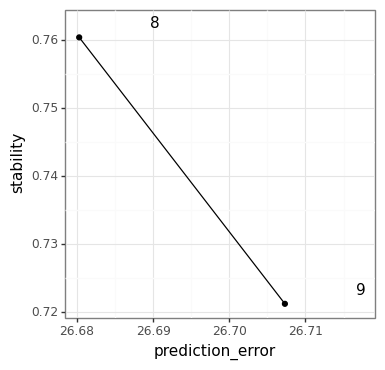

In [57]:
stat_df = check_stat("cNMF_atacG/cNMF_atacG_fibro", K, plot=True)

### K = 8
Reusing some of Ni's old plots

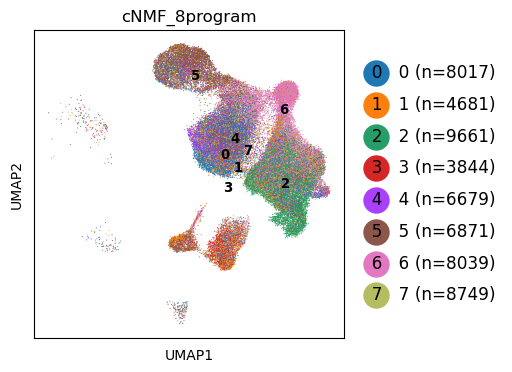

In [45]:
cnmf_atacG_k8_top20genes = examine_k(
    "cNMF_atacG/cNMF_atacG_fibro", k=8, adata=atacG_ad1, plot=True, n_top_genes=20
)

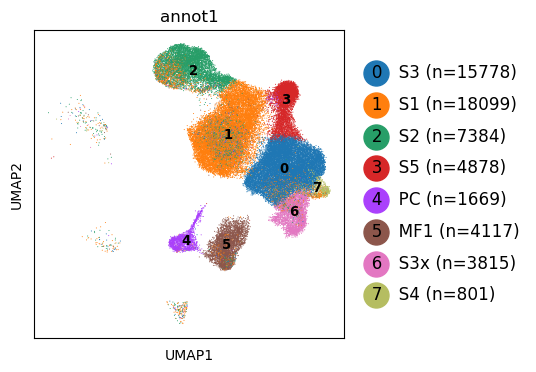

In [46]:
sk.clear_colors(atacG_ad1)
sk.plot_embedding(atacG_ad1, basis="umap", groupby="annot1", annot="full");

In [58]:
sk.cross_table(atacG_ad1, "annot1", "cNMF_8program", normalise="xy")  # used to be a heatmap, but plot function was dropped from sctk

cNMF_8program,0,1,2,3,4,5,6,7
annot1,,,,,,,,
S3,0.0342,0.1077,0.3019,0.0825,0.1352,0.0035,0.0986,0.1522
S1,0.6517,0.0783,0.0018,0.0540,0.1947,0.0317,0.0961,0.1399
S2,0.0102,0.0687,0.0000,0.0235,0.0636,0.6304,0.0122,0.0939
S5,0.0034,0.1060,0.0299,0.0035,0.0655,0.0014,0.5743,0.0941
PC,0.0070,0.2102,0.0041,0.2223,0.0322,0.3088,0.0876,0.1289
MF1,0.2232,0.2482,0.0041,0.4597,0.0144,0.0223,0.0608,0.1627
S3x,0.0013,0.0349,0.6126,0.0428,0.0307,0.0009,0.0013,0.0846
S4,0.0690,0.1460,0.0455,0.1117,0.4637,0.0011,0.0691,0.1438


In [51]:
cnmf_atacG_k8_top20genes

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,MIR4418,CCL8,FABP5,TM4SF1,TCIM,CCL13,MIR4679-2,FFAR2,LINC01959,LINC01914,MIR3935,CXCL1,MIR6720,LOC100130238,MIR4774,MAB21L2,TM4SF1-AS1,MIR4263,ZEB2-AS1,MIR6774
2,LINGO2,RIMS1,MIR17HG,MIR924HG,OR4K2,MIR8080,MIR17,MIR18A,MIR19A,MRGPRX1,MIR20A,MIR19B1,MIR92A1,SNORA70C,ZWINT,MIR4431,ARPP21,FSTL5,MIR1261,MIR551B
3,MGP,MIR5092,HAND2,MIR4693,LINC01736,TNNT3,C1QTNF3,MIR2117,PLA2G2A,LOC105370024,LINC02308,LOC101929106,MIR4486,FABP3,LINC01213,MIR3149,THBS2,TUB-AS1,MIR5186,SERTAD4-AS1
4,GABARAP,ILF3-DT,POLR2I,MIR3940,MIR1227,LOC105369340,PLEKHJ1,MIR6789,TMEM141,RNF5,FKBP2,MIR638,C9orf163,EIF5A,BRICD5,PGP,C19orf24,TMEM256,U2AF1L4,SSSCA1-AS1
5,FAM166A,STPG3,PLK2,BAIAP2-DT,NELFB,SNAI1,STPG3-AS1,GALK1,NXF1,LBHD1,HMBS,MIR6514,UQCC3,FLJ42351,PEAK3,C11orf98,SPSB2,GGCX,HIST1H2AG,MIR4639
6,MYCBPAP,LOC100506388,MIR3193,FFAR2,DERL3,ID1,PTP4A3,ABHD16B,CXCR4,LOC101927000,FOXL1,MIR4418,TIMM22,LAMA5-AS1,THEG5,NANOS1,CD3E,ZP1,LINC00322,MIR1182
7,ICAM1,ICAM5,IL10,ICAM4,HTR1D,SEMA4A,CXCL3,LOC101927839,HOXA10,CSF3,MIR6769B,MIR4425,CXCL2,ITGB2-AS1,SERPINA2,MIR330,TNFSF14,HOXA10-AS,MIR7850,LL22NC01-81G9.3
8,MIR20A,MIR19B1,MIR19A,MIR18A,MIR17,MIR92A1,MIR17HG,SNORA4,SNORA63,SNORA81,MIR1248,EIF4A2,SNORD2,RPL7,SMS,MIR580,ANO4,HS6ST2,MIRLET7I,LINC01465


In [53]:
cnmf_atacG_k8_signf_terms = pd.concat(
    [
        sc.queries.enrich(cnmf_atacG_k8_top20genes.loc[i + 1].to_list())
        .where(lambda x: (x.p_value < 0.05) & (x.intersection_size >= 2))
        .dropna()
        .assign(program=i)
        for i in range(8)
    ]
)

In [54]:
cnmf_atacG_k8_signf_terms.groupby("program").head(3)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,program
0,GO:MF,GO:0008009,chemokine activity,1.062664e-04,True,"""The function of a family of small chemotactic...",50.0,8.0,3.0,20195.0,0.375000,0.060000,query_1,"[GO:0005125, GO:0042379]",0
1,GO:MF,GO:0042379,chemokine receptor binding,3.498941e-04,True,"""Binding to a chemokine receptor."" [GOC:ai]",74.0,8.0,3.0,20195.0,0.375000,0.040541,query_1,"[GO:0001664, GO:0005126]",0
2,KEGG,KEGG:04061,Viral protein interaction with cytokine and cy...,7.784760e-04,True,Viral protein interaction with cytokine and cy...,98.0,5.0,3.0,8161.0,0.600000,0.030612,query_1,[KEGG:00000],0
0,WP,WP:WP1545,miRNAs involved in DNA damage response,8.547699e-10,True,miRNAs involved in DNA damage response,68.0,8.0,6.0,8133.0,0.750000,0.088235,query_1,[WP:000000],1
1,GO:CC,GO:0016442,RISC complex,3.343539e-08,True,"""A ribonucleoprotein complex that contains mem...",436.0,16.0,8.0,22122.0,0.500000,0.018349,query_1,[GO:0031332],1
2,GO:CC,GO:0031332,RNAi effector complex,3.343539e-08,True,"""Any protein complex that mediates the effects...",436.0,16.0,8.0,22122.0,0.500000,0.018349,query_1,[GO:1990904],1
0,TF,TF:M04059,Factor: NRF-1; motif: YGCGCATGCGCN,4.599290e-03,True,Factor: NRF-1; motif: YGCGCATGCGCN,1494.0,11.0,7.0,20011.0,0.636364,0.004685,query_1,[TF:M00000],3
1,TF,TF:M09641,Factor: NRF-1; motif: SYGCGCMTGCGCRNNGSN,5.138730e-03,True,Factor: NRF-1; motif: SYGCGCMTGCGCRNNGSN,3303.0,11.0,9.0,20011.0,0.818182,0.002725,query_1,[TF:M00000],3
2,TF,TF:M04694,Factor: NRF-1; motif: CNCTGCGCATGCGC,6.903775e-03,True,Factor: NRF-1; motif: CNCTGCGCATGCGC,1587.0,11.0,7.0,20011.0,0.636364,0.004411,query_1,[TF:M00000],3
0,TF,TF:M12170,Factor: AP-2rep; motif: NRCCACGCCCN,1.785511e-02,True,Factor: AP-2rep; motif: NRCCACGCCCN,211.0,14.0,4.0,20011.0,0.285714,0.018957,query_1,[TF:M00000],4


In [55]:
!ls

cNMF_atacG	  run_cNMF_scATAC2.ipynb  visual_cNMF_scATAC3.ipynb
cNMF_atacG_fibro  run_cNMF_scATAC3.ipynb


# Run cNMF for peak count data
Simon: main analysis

In [145]:
gc.collect()

15108

In [146]:
!mkdir -p cNMF_atacP

In [147]:
atacP_tfidf_ad.var_names[0:5]

Index(['chr1:794840-795340,FAM87B,Distal', 'chr1:807550-808050,FAM87B,Distal',
       'chr1:811011-811511,FAM87B,Distal',
       'chr1:817090-817590,FAM87B,Promoter',
       'chr1:817824-818324,FAM87B,Exonic'],
      dtype='object', name='index')

In [149]:
#K = [13, 14, 15, 16, 17, 18, 19, 20]  # batch 1
K = [10, 11, 12, 21, 22, 23, 24, 25]  # batch 2

In [150]:
sk._utils.run_cNMF(
    atacP_tfidf_ad,
    K=K,
    use_rep="X",
    rep_type="lognorm",
    n_worker=16,
    use_cache=False,
    output_prefix="cNMF_atacP/cNMF_atacP",
)

k = 10 done
k = 11 done
k = 12 done
k = 21 done
k = 22 done
k = 23 done
k = 24 done
k = 25 done


In [48]:
!ls cNMF_atacP/

cNMF_atacP.gene_spectra.k_13.csv.gz
cNMF_atacP.gene_spectra.k_14.csv.gz
cNMF_atacP.gene_spectra.k_15.csv.gz
cNMF_atacP.gene_spectra.k_16.csv.gz
cNMF_atacP.gene_spectra.k_17.csv.gz
cNMF_atacP.gene_spectra.k_18.csv.gz
cNMF_atacP.gene_spectra.k_19.csv.gz
cNMF_atacP.gene_spectra.k_20.csv.gz
cNMF_atacP.gene_spectra_tpm.k_13.csv.gz
cNMF_atacP.gene_spectra_tpm.k_14.csv.gz
cNMF_atacP.gene_spectra_tpm.k_15.csv.gz
cNMF_atacP.gene_spectra_tpm.k_16.csv.gz
cNMF_atacP.gene_spectra_tpm.k_17.csv.gz
cNMF_atacP.gene_spectra_tpm.k_18.csv.gz
cNMF_atacP.gene_spectra_tpm.k_19.csv.gz
cNMF_atacP.gene_spectra_tpm.k_20.csv.gz
cNMF_atacP.spectra.k_13.consensus.csv.gz
cNMF_atacP.spectra.k_14.consensus.csv.gz
cNMF_atacP.spectra.k_15.consensus.csv.gz
cNMF_atacP.spectra.k_16.consensus.csv.gz
cNMF_atacP.spectra.k_17.consensus.csv.gz
cNMF_atacP.spectra.k_18.consensus.csv.gz
cNMF_atacP.spectra.k_19.consensus.csv.gz
cNMF_atacP.spectra.k_20.consensus.csv.gz
cNMF_atacP.spectral.k13.combined.csv.gz
cNMF_atacP.spectral.k14.

## Examine

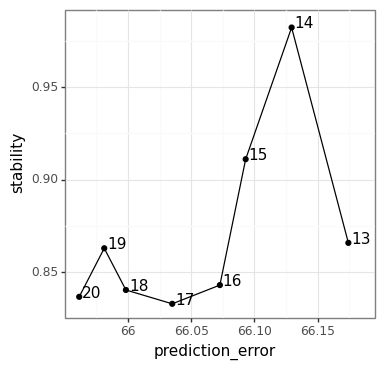

In [49]:
stat_df = check_stat("cNMF_atacP/cNMF_atacP", K, plot=True)

## Preliminary investigation of tested K-values

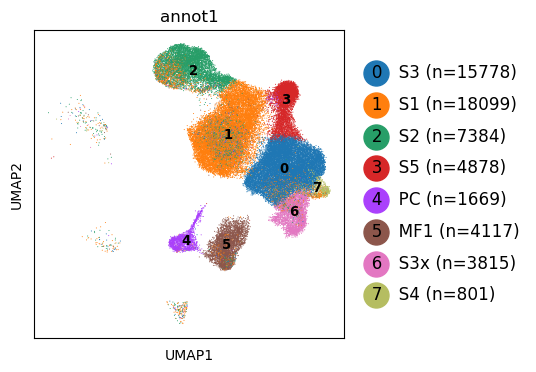

In [139]:
sk.clear_colors(atacG_ad1)
sk.plot_embedding(atacG_ad1, basis="umap", groupby="annot1", annot="full");

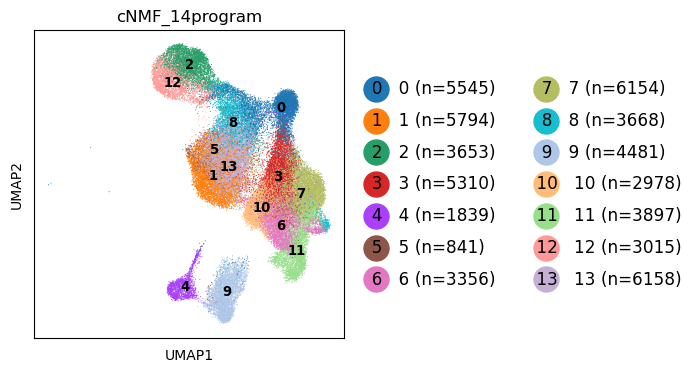

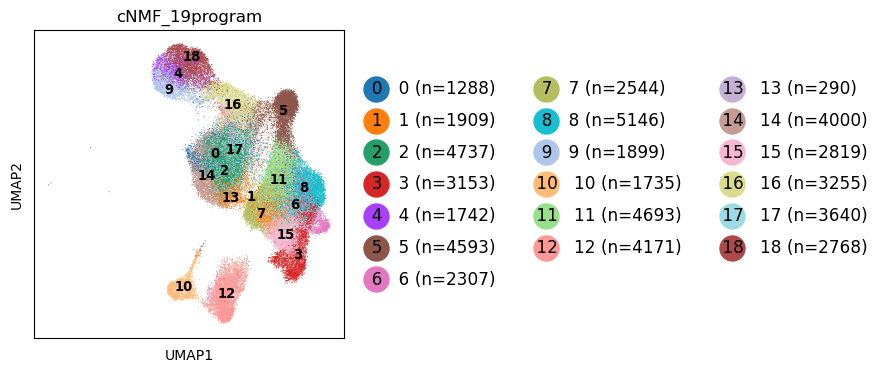

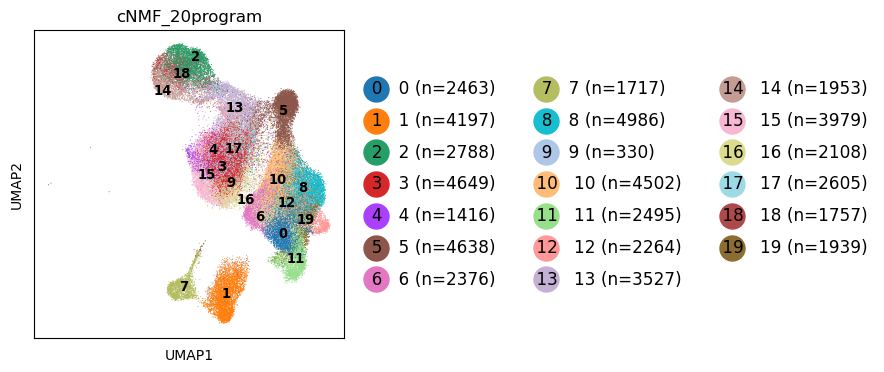

In [148]:
examine_k(
    "cNMF_atacP/cNMF_atacP", k=14, adata=atacP_ad, plot=True, n_top_genes=50
);
examine_k(
    "cNMF_atacP/cNMF_atacP", k=19, adata=atacP_ad, plot=True, n_top_genes=50
);
examine_k(
    "cNMF_atacP/cNMF_atacP", k=20, adata=atacP_ad, plot=True, n_top_genes=50
);

In [144]:
k = 14

cnmf_atacP_top50peaks = examine_k(
    "cNMF_atacP/cNMF_atacP", k=14, adata=atacP_ad, plot=False, n_top_genes=50
)

In [138]:
sk.cross_table(atacP_ad, "annot1", "cNMF_14program", normalise="xy")

cNMF_14program,0,1,2,3,4,5,6,7,8,9,10,11,12,13
annot1,,,,,,,,,,,,,,
S3,0.0004,0.0055,0.0005,0.4949,0.0048,0.1205,0.2101,0.5844,0.0040,0.0050,0.9340,0.0548,0.0006,0.0028
S1,0.0935,0.9896,0.0073,0.0456,0.0044,0.4476,0.0074,0.0180,0.2529,0.0204,0.0164,0.0002,0.0070,0.9968
S2,0.0520,0.0033,0.9918,0.0003,0.0008,0.0766,0.0000,0.0000,0.1062,0.0023,0.0041,0.0000,0.9911,0.0004
S5,0.8198,0.0000,0.0004,0.4272,0.0024,0.0306,0.0000,0.0629,0.0034,0.0059,0.0073,0.0014,0.0000,0.0000
PC,0.0252,0.0000,0.0000,0.0000,0.9702,0.0081,0.0000,0.0000,0.0010,0.0018,0.0000,0.0000,0.0000,0.0000
MF1,0.0091,0.0015,0.0000,0.0069,0.0036,0.1085,0.0003,0.0004,0.0207,0.9594,0.0050,0.0000,0.0012,0.0000
S3x,0.0000,0.0000,0.0000,0.0149,0.0013,0.0214,0.2259,0.0069,0.0000,0.0003,0.0268,0.9436,0.0000,0.0000
S4,0.0000,0.0000,0.0000,0.0102,0.0124,0.1867,0.5562,0.3274,0.6119,0.0050,0.0064,0.0000,0.0000,0.0000


In [190]:
cnmf_atacP_k14_top50peaks.T.iloc[0:4, 0:4]

,1,2,3,4
0,"chr2:127410483-127410983,PROC,Distal","chr17:28716833-28717333,NA,Intronic","chr20:44582169-44582669,PKIG,Intronic","chr6:95087371-95087871,MANEA-DT,Distal"
1,"chr12:132561098-132561598,MIR6763,Intronic","chr10:70582642-70583142,PRF1,Distal","chr7:131568525-131569025,PODXL,Distal","chr12:58893972-58894472,LRIG3,Intronic"
2,"chr3:139655800-139656300,NMNAT3,Intronic","chr12:57429706-57430206,R3HDM2,Intronic","chr8:22313606-22314106,PIWIL2,Intronic","chr10:100562907-100563407,NDUFB8,Distal"
3,"chr8:127725647-127726147,CASC11,Intronic","chr3:149401383-149401883,TM4SF1,Distal","chr11:65503966-65504466,MALAT1,Exonic","chr21:32329285-32329785,MRAP,Intronic"


In [193]:
cnmf_atacP_k14_top50peaks.to_csv("cNMF_atacP/cNMF_atacP.top50_peaks_per_program.k_14.csv.gz", header=False)

In [153]:
cnmf_atacP_k14_top20genes = cnmf_atacP_k14_top20peaks.replace(regex={r"^[^,]*,": ""}).replace(
    regex={r",[^,]*$": ""}
)

In [156]:
cnmf_atacP_k14_top20genes

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,PROC,MIR6763,NMNAT3,CASC11,C3orf49,LINC02189,ATP5PF,MYT1L,PRR20B,DNAJC3,TSEN15,MIR4480,RAD51B,SRSF5,OR2AT4,LAMA2,SLC8A3,LOC101927421,LINC00113,OPCML
2,NA,PRF1,R3HDM2,TM4SF1,SKIL,FAM50B,FGF2,MIR4636,INSM1,MIR6809,UBAC1,LINC00972,ALG10,TNS1,BTBD16,MIR2110,CYP11A1,EDAR,LINC01080,ACBD3
3,PKIG,PODXL,PIWIL2,MALAT1,PIWIL2,KAZN,LOC100507071,CAMTA1,LOC100507071,PRDM8,LINC00445,ARHGAP25,GALNT11,PODXL,MIR6133,AKAP11,RNF112,TANK,PREP,PRKAG2-AS1
4,MANEA-DT,LRIG3,NDUFB8,MRAP,PCCB,CRTC1,CCT4,CABCOCO1,TNFRSF25,NRG1-IT1,MIR147A,PLEKHG5,ATN1,TMEM30B,MIR3942,ANK2,TAB2,ACKR3,AANAT,IFNG-AS1
5,MYL12A,NECTIN3-AS1,DPH6-DT,COL28A1,SNX18,FIG4,LINC02541,C1orf198,LOC105378367,ARHGAP32,C11orf91,PDE9A,RSPH1,APBA2,SLC2A3,LINC01271,ADAMTS9,ZC3H7A,C4orf51,MIR3200
6,SYNJ2-IT1,MIR2113,SLX4IP,WSB1,MAML3,FPR3,PQLC2,SHB,ASPN,SYNJ2-IT1,LINC00845,LINC00689,NRARP,LCLAT1,PAPPA2,MIR1266,E2F7,FAM20A,CCDC91,TGFBR2
7,KCNG2,BMP7,HSPA12A,NR2E3,MAPRE1,LGALSL,FAM216B,MTRNR2L3,MIR3074,LOC349160,NT5M,RAPGEF1,SLC1A3,ITGA1,PDPN,CCR1,STMND1,C20orf78,ACSBG2,FBXO22
8,MYO16-AS1,CTB-178M22.2,TMEM150A,IZUMO3,LINC00316,MIR629,CDAN1,LOC105372028,PLN,CST7,KBTBD3,TMED10,CTNNBL1,C17orf107,TMIGD1,PLSCR2,PSMG4,KPNA1,HLA-DMA,LRP1B
9,MIR578,STAC,MIR1302-4,TMCO1,ESM1,FAM118A,LAMA4,AGPAT2,PAG1,FSCN1,MIR383,RPS6KA2-AS1,LOC642852,MIR4260,LINC02554,COL4A2,COL19A1,ADORA2A-AS1,LOC101927851,MIR3199-1
10,RPS27A,PRICKLE2-AS3,MYO16-AS1,DCUN1D1,DPF1,DCT,MIR6870,LINC01101,MTFR2,GCOM1,SFMBT2,EFNA5,MMP16,RAPH1,MIR124-2,RBM18,BCL2L1,PHF21A,CDKAL1,MYADM


In [154]:
cnmf_atacP_k14_signf_terms = pd.concat(
    [
        sc.queries.enrich(cnmf_atacP_k14_top20genes.loc[i + 1].to_list())
        .where(lambda x: (x.p_value < 0.05) & (x.intersection_size >= 2))
        .dropna()
        .assign(program=i)
        for i in range(14)
    ]
)

In [155]:
cnmf_atacP_k14_signf_terms.groupby("program").head(3)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,program
0,MIRNA,MIRNA:hsa-miR-3691-3p,hsa-miR-3691-3p,0.008945,True,hsa-miR-3691-3p,105.0,9.0,3.0,14830.0,0.333333,0.028571,query_1,[MIRNA:000000],1
1,GO:BP,GO:0061101,neuroendocrine cell differentiation,0.011760,True,"""The process in which a relatively unspecializ...",9.0,11.0,2.0,21029.0,0.181818,0.222222,query_1,[GO:0060563],1
0,GO:CC,GO:0005737,cytoplasm,0.039083,True,"""The contents of a cell excluding the plasma m...",12193.0,14.0,14.0,21672.0,1.000000,0.001148,query_1,"[GO:0005622, GO:0110165]",3
0,HP,HP:0031589,Suicidal ideation,0.016467,True,Frequent thinking about or preoccupation with ...,14.0,3.0,2.0,4667.0,0.666667,0.142857,query_1,[HP:0100851],4
0,WP,WP:WP4658,Small cell lung cancer,0.003276,True,Small cell lung cancer,98.0,6.0,3.0,7806.0,0.500000,0.030612,query_1,[WP:000000],8
1,GO:MF,GO:0005201,extracellular matrix structural constituent,0.012282,True,"""The action of a molecule that contributes to ...",173.0,10.0,3.0,20166.0,0.300000,0.017341,query_1,[GO:0005198],8
2,REAC,REAC:R-HSA-3000157,Laminin interactions,0.023034,True,Laminin interactions,30.0,6.0,2.0,10760.0,0.333333,0.066667,query_1,[REAC:R-HSA-1474244],8
0,REAC,REAC:R-HSA-9648002,RAS processing,0.031680,True,RAS processing,24.0,8.0,2.0,10760.0,0.250000,0.083333,query_1,[REAC:R-HSA-5673001],9
1,REAC,REAC:R-HSA-9682385,FLT3 signaling in disease,0.040244,True,FLT3 signaling in disease,27.0,8.0,2.0,10760.0,0.250000,0.074074,query_1,[REAC:R-HSA-5663202],9
0,KEGG,KEGG:00512,Mucin type O-glycan biosynthesis,0.013472,1.0,Mucin type O-glycan biosynthesis,36.0,6.0,2.0,8014.0,0.333333,0.055556,query_1,[KEGG:00000],11


In [182]:
!rclone copy cNMF_atacP/cNMF_atacP.usage.k_14.consensus.csv.gz google:/projects/Matthias_ATAC/data/cNMF/scATAC_peak/

In [183]:
!rclone copy cNMF_atacP/cNMF_atacP.spectra.k_14.consensus.csv.gz google:/projects/Matthias_ATAC/data/cNMF/scATAC_peak/

In [193]:
cnmf_atacP_k14_top50peaks.to_csv("cNMF_atacP/cNMF_atacP.top50_peaks_per_program.k_14.csv.gz", header=False)

In [194]:
!rclone copy cNMF_atacP/cNMF_atacP.top50_peaks_per_program.k_14.csv.gz google:/projects/Matthias_ATAC/data/cNMF/scATAC_peak/